In [1]:
import pandas as pd
sentiment = pd.read_csv("/content/fear_greed_index.csv")
trades = pd.read_csv("/content/historical_data.csv")

In [2]:
print(sentiment.shape)
print(trades.shape)

(2644, 4)
(211224, 16)


In [4]:
print(sentiment.isnull().sum())


timestamp         0
value             0
classification    0
date              0
dtype: int64


In [5]:
print(trades.isnull().sum())

Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
dtype: int64


In [6]:
print(sentiment.duplicated().sum())

0


In [7]:
print(trades.duplicated().sum())

0


In [9]:
sentiment['date'] = pd.to_datetime(sentiment['date'])
sentiment['date'] = sentiment['date'].dt.date

In [13]:
trades.columns = trades.columns.str.strip().str.lower().str.replace(" ", "_")

print(trades.columns)

Index(['account', 'coin', 'execution_price', 'size_tokens', 'size_usd', 'side',
       'timestamp_ist', 'start_position', 'direction', 'closed_pnl',
       'transaction_hash', 'order_id', 'crossed', 'fee', 'trade_id',
       'timestamp'],
      dtype='object')


In [15]:
trades['timestamp_ist'] = pd.to_datetime(
    trades['timestamp_ist'],
    dayfirst=True
)

In [17]:
trades['date'] = trades['timestamp_ist'].dt.date

In [18]:
merged = trades.merge(
    sentiment[['date','classification']],
    on='date',
    how='left'
)

merged.head()

,account,coin,execution_price,size_tokens,size_usd,side,timestamp_ist,start_position,direction,closed_pnl,transaction_hash,order_id,crossed,fee,trade_id,timestamp,date,classification
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,2024-12-02 22:50:00,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12,2024-12-02,Extreme Greed
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,2024-12-02 22:50:00,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12,2024-12-02,Extreme Greed
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,2024-12-02 22:50:00,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12,2024-12-02,Extreme Greed
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,2024-12-02 22:50:00,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12,2024-12-02,Extreme Greed
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,2024-12-02 22:50:00,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12,2024-12-02,Extreme Greed


In [19]:
merged['classification'].isnull().mean()

np.float64(2.840586297011703e-05)

In [20]:
daily_pnl = (
    merged
    .groupby(['account','date'])['closed_pnl']
    .sum()
    .reset_index()
)

In [21]:
merged['win'] = merged['closed_pnl'] > 0

In [22]:
win_rate = merged.groupby('account')['win'].mean()
win_rate.head()

,win
account,
0x083384f897ee0f19899168e3b1bec365f52a9012,0.359612
0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,0.442720
0x271b280974205ca63b716753467d5a371de622ab,0.301917
0x28736f43f1e871e6aa8b1148d38d4994275d72c4,0.438585
0x2c229d22b100a7beb69122eed721cee9b24011dd,0.519914


In [23]:
trades_per_day = merged.groupby('date').size()

In [24]:
ls_ratio = merged.groupby(['date','direction']).size().unstack()
ls_ratio.head()

direction,Auto-Deleveraging,Buy,Close Long,Close Short,Liquidated Isolated Short,Long > Short,Open Long,Open Short,Sell,Settlement,Short > Long,Spot Dust Conversion
date,,,,,,,,,,,,
2023-05-01,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN
2023-12-05,NaN,NaN,NaN,NaN,NaN,NaN,7.0,2.0,NaN,NaN,NaN,NaN
2023-12-14,NaN,NaN,4.0,2.0,NaN,NaN,3.0,2.0,NaN,NaN,NaN,NaN
2023-12-15,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-16,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN


In [25]:
merged.groupby('classification')['closed_pnl'].mean()

,closed_pnl
classification,
Extreme Fear,34.537862
Extreme Greed,67.892861
Fear,54.290400
Greed,42.743559
Neutral,34.307718


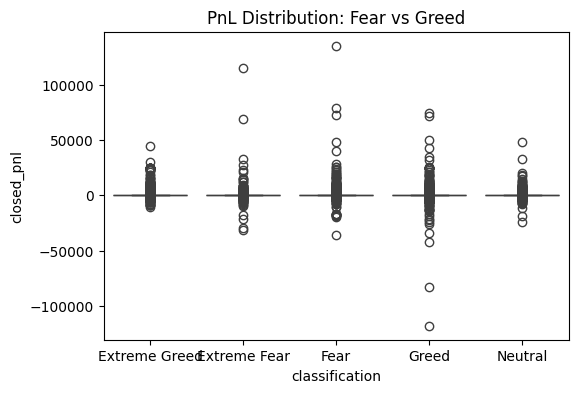

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.boxplot(x='classification', y='closed_pnl', data=merged)
plt.title("PnL Distribution: Fear vs Greed")
plt.show()

In [27]:
merged.groupby('classification')['win'].mean()

,win
classification,
Extreme Fear,0.370607
Extreme Greed,0.464943
Fear,0.420768
Greed,0.384828
Neutral,0.396991


In [29]:
print(merged.columns)

Index(['account', 'coin', 'execution_price', 'size_tokens', 'size_usd', 'side',
       'timestamp_ist', 'start_position', 'direction', 'closed_pnl',
       'transaction_hash', 'order_id', 'crossed', 'fee', 'trade_id',
       'timestamp', 'date', 'classification', 'win'],
      dtype='object')


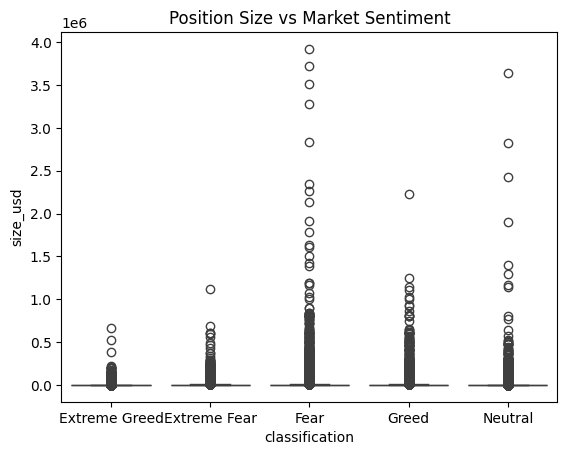

In [30]:
sns.boxplot(x='classification', y='size_usd', data=merged)
plt.title("Position Size vs Market Sentiment")
plt.show()

In [31]:
daily_metrics = (
    merged
    .groupby(['account', 'date', 'classification'])
    .agg(
        daily_pnl=('closed_pnl', 'sum'),
        trades_count=('closed_pnl', 'count'),
        avg_size=('size_usd', 'mean'),
        win_rate=('win', 'mean')
    )
    .reset_index()
)

In [32]:
daily_metrics.groupby('classification')['daily_pnl'].mean()

,daily_pnl
classification,
Extreme Fear,4619.439053
Extreme Greed,5161.922644
Fear,5328.818161
Greed,3318.100730
Neutral,3438.618818


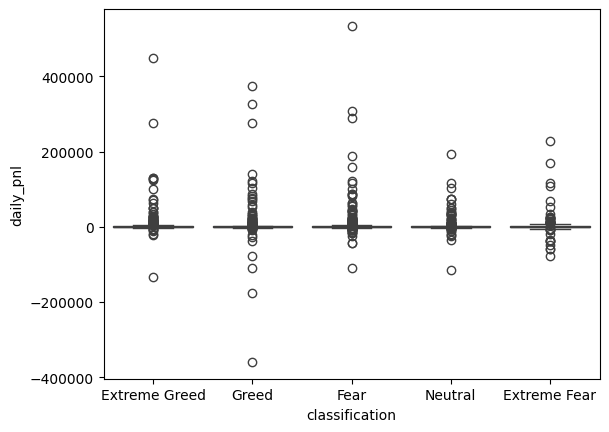

In [33]:
sns.boxplot(x='classification', y='daily_pnl', data=daily_metrics)
plt.show()

In [34]:
daily_metrics.groupby('classification')['trades_count'].mean()
daily_metrics.groupby('classification')['avg_size'].mean()

,avg_size
classification,
Extreme Fear,6773.464125
Extreme Greed,5371.637182
Fear,8975.928546
Greed,6427.866594
Neutral,6963.694861


In [36]:
daily_metrics['loss_flag'] = daily_metrics['daily_pnl'] < 0

In [37]:
upper_limit = daily_metrics['daily_pnl'].quantile(0.99)
filtered = daily_metrics[daily_metrics['daily_pnl'] < upper_limit]

In [38]:
from sklearn.linear_model import LogisticRegression

daily_metrics['profitable'] = daily_metrics['daily_pnl'] > 0

X = daily_metrics[['trades_count','avg_size']]
y = daily_metrics['profitable']

In [39]:
from sklearn.model_selection import train_test_split

X = daily_metrics[['trades_count','avg_size']]
y = daily_metrics['profitable']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [41]:
from sklearn.metrics import accuracy_score

y_pred = model.predict(X_test)

print("Model Accuracy:", accuracy_score(y_test, y_pred))

Model Accuracy: 0.6068376068376068
